In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
from torchvision import transforms
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split

# Read training data

In [2]:
# Reading data
key_points_frame = pd.read_csv('/content/drive/My Drive/input/data/training_frames_keypoints.csv')

key_points_frame.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


# Display some information about the data

In [3]:
# Display one image statistics for better understanding
n = 0
image_name = key_points_frame.iloc[n,0]
key_points = (key_points_frame.iloc[n,1:]).to_numpy()
key_points = key_points.astype('float').reshape(-1,2)

print(f"Image name: {image_name}")
print(f"Landmarks shape: {key_points.shape}")
print(f"First 5 key points:\n{key_points[:5]}")

Image name: Luis_Fonsi_21.jpg
Landmarks shape: (68, 2)
First 5 key points:
[[ 45.  98.]
 [ 47. 106.]
 [ 49. 110.]
 [ 53. 119.]
 [ 56. 125.]]


# Look at images with keypoints

#### Below there is a function __show_keypoints__, that takes in an image and keypoints and displays them.

In [4]:
def show_keypoints(image, key_points):
    """Show images with keypoints"""
    plt.imshow(image)
    plt.scatter(key_points[:, 0], key_points[:, 1], s=20, c='b')

#### As these images are not all of the same size (and neither are the faces), we will need to standartize their shape to train a NN.

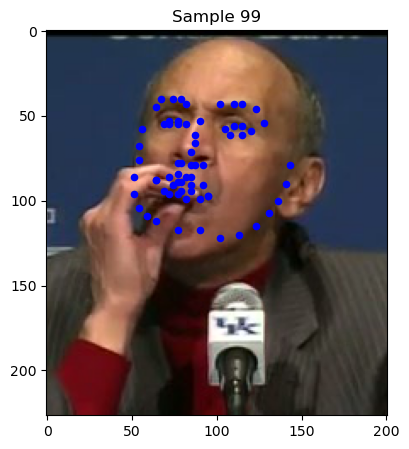

In [5]:
# Display different images by changing the index
index = 99

image_name = key_points_frame.iloc[index, 0]
key_points = key_points_frame.iloc[index, 1:].to_numpy()
key_points = key_points.astype('float').reshape(-1,2)

plt.figure(figsize=(5,5))
show_keypoints(mpimg.imread(os.path.join('data/training/', image_name)), key_points)
plt.title(f'Sample {index}')
plt.show()

# Custom Dataset Class

#### To prepare our data for training, we'll be using PyTorch's Dataset class.

#### We will override the following methods:

* __len__ so that len(dataset) returns the size of the dataset.
* __getitem__ to support the indexing such that dataset[i] can be used to get the i-th sample of image/keypoint data.

#### A sample of our dataset will be a dictionary {'image': image, 'keypoints': key_points}.

#### Our dataset will take an optional argument __transform__ so that any required processing can be applied on the sample.

In [6]:
class FaceKeypointsDataset(Dataset):
    """
    Marked face images Dataset Class.\n

    Args:
        csv_file (str): Path to the csv file.
        root_dir (str): Directory with all the images.
        transform (callable, optional): Optional transform to be apllied on a sample.
    """

    def __init__(self, csv_file, root_dir, transform=None):
        self.key_points_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.key_points_frame)

    def __getitem__(self, idx):
        # Image
        image_name = os.path.join(self.root_dir, self.key_points_frame.iloc[idx, 0])
        image = mpimg.imread(image_name)

        # Check whether the image is single-channel
        if image.ndim == 2:
            # Convert from single-channel to three-channel, repeating the channel in depth
            image = np.stack((image,)*3, axis=-1)
        # If image has an alpha color channel, get rid of it
        elif (image.shape[2] == 4):
            image = image[:, :, 0:3]

        # Keypoints
        key_points = self.key_points_frame.iloc[idx, 1:].to_numpy()
        key_points = key_points.astype('float').reshape(-1, 2)

        # Our sample
        sample = {'image': image, 'keypoints': key_points}

        # transforms
        if self.transform:
            sample = self.transform(sample)

        return sample

# Create an instance of the class

In [7]:
# instance of our custom dataset
face_dataset = FaceKeypointsDataset(csv_file='/content/drive/My Drive/input/data/training_frames_keypoints.csv', root_dir='/content/drive/My Drive/input/data/training/')

print(f"Length of the dataset: {len(face_dataset)}")

Length of the dataset: 3462


# Display some images and its shapes

0 (147, 143, 3) (68, 2)
1 (185, 180, 3) (68, 2)
2 (197, 192, 3) (68, 2)


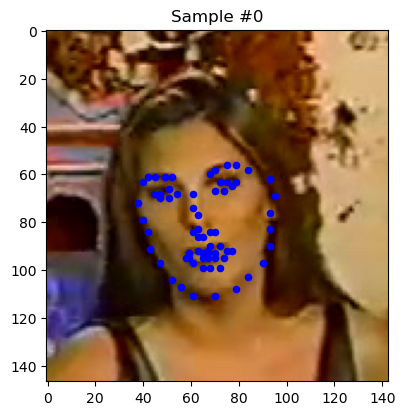

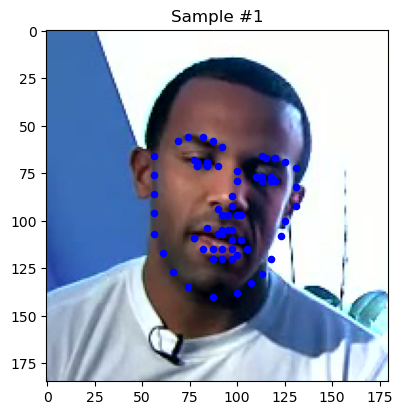

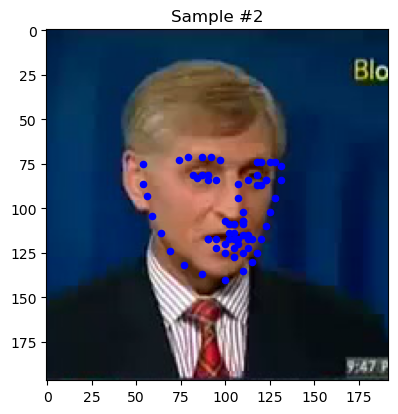

In [8]:
# Display a few images from the dataset
num_to_display = 3

for i in range(num_to_display):

    # define the size of images
    fig = plt.figure(figsize=(15,12))

    # randomly select a sample
    rand_i = np.random.randint(0, len(face_dataset))
    sample = face_dataset[rand_i]

    # print the shape of the image and keypoints
    print(i, sample['image'].shape, sample['keypoints'].shape)

    ax = plt.subplot(1, num_to_display, i+1)
    ax.set_title(f"Sample #{i}")

    # using the same display function show_keypoints, defined earlier
    show_keypoints(sample['image'], sample['keypoints'])

# Transformations

#### The images above are not of the same size, and NN often expect images with fixed size and a normalized range for color ranges, and for Pytorch converted to Tensors.

#### Therefore, we will do some transforms:
* __Normalize__: to convert an image values with a range of [0,1].
* __Rescale__: to rescale an image to desired size.
* __ToTensor__: to convert numpy to torch

#### Also we will do some additional transforms for data augmentation:
* __RandomRotation__: to rotate the image randomly.
* __AddNoise__: to add random noise to the image.

#### We will use callable classes instead of functions to avoid passing parameters on each call. So, we need to implement the __call__ and __init__ (if we required parameters to be passed) methods.

In [9]:
class Normalize(object):
    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']
        h, w = image.shape[:2]
        return {'image': image / 255.0, 'keypoints': key_points / [w, h]}

class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        img = cv2.resize(image, (new_w, new_h))
        key_points = key_points * [new_w / w, new_h / h]
        return {'image': img, 'keypoints': key_points}


# Random Rotation
class RandomRotation(object):
    """Randomly rotate the image."""

    def __init__(self, degrees=90):
        self.degrees = degrees

    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']

        # Define the rotation
        angle = random.uniform(-self.degrees, self.degrees)
        rotation_mat = cv2.getRotationMatrix2D((image.shape[1]/2, image.shape[0]/2), angle, 1)

        # Rotate image
        rotated_image = cv2.warpAffine(image, rotation_mat, (image.shape[1], image.shape[0]))

        # Rotate keypoints
        ones = np.ones(shape=(len(key_points), 1))
        points_ones = np.hstack([key_points, ones])
        transformed_keypoints = rotation_mat.dot(points_ones.T).T

        return {'image': rotated_image, 'keypoints': transformed_keypoints}


# Add noise
class AddNoise(object):
    """Add random noise to the image."""

    def __init__(self, noise_level=0.1):
        self.noise_level = noise_level

    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']

        # Generate random noise
        noise = np.random.normal(scale=self.noise_level, size=image.shape)

        # Add noise to the image
        noisy_image = image + noise

        # Clip pixel values to stay within [0, 255]
        noisy_image = np.clip(noisy_image, 0, 255)

        return {'image': noisy_image.astype(np.uint8), 'keypoints': key_points}


class ToTensor(object):
    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']
        if len(image.shape) == 2:
            image = image.reshape(image.shape[0], image.shape[1], 1)
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image), 'keypoints': torch.from_numpy(key_points)}

# Create the tranformed base_dataset

In [10]:
# Define the data transform
base_transform = transforms.Compose([
    Rescale((224,224)),
    Normalize(),
    ToTensor()
])

# Create an instance of custom transformed base_dataset
base_dataset = FaceKeypointsDataset(csv_file='/content/drive/My Drive/input/data/training_frames_keypoints.csv', root_dir='/content/drive/My Drive/input/data/training/', transform=base_transform)

In [11]:
print('Length of dataset : ', len(base_dataset))

for i in range(5):
    sample = base_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Length of dataset :  3462
0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])
4 torch.Size([3, 224, 224]) torch.Size([68, 2])


In [12]:
test_dataset = FaceKeypointsDataset(csv_file='/content/drive/My Drive/input/data/test_frames_keypoints.csv', root_dir='/content/drive/My Drive/input/data/test/', transform=base_transform)

In [13]:
print('Length of dataset : ', len(test_dataset))

Length of dataset :  770


# Add augmentations

In [14]:
# Define transformations for the train dataset
augmentation_transform = transforms.Compose([
    Rescale((224,224)),
    RandomRotation(90),
    AddNoise(noise_level=0.1),
    Normalize(),
    ToTensor()
])

# Create a new dataset with augmentations
augmented_dataset = FaceKeypointsDataset(csv_file='/content/drive/My Drive/input/data/training_frames_keypoints.csv', root_dir='/content/drive/My Drive/input/data/training/', transform=augmentation_transform)

# Merge a base dataset with an augmented dataset
merged_train_dataset = ConcatDataset([base_dataset, augmented_dataset])

In [15]:
print(f"Length of data with augmentations: {len(merged_train_dataset)}")

Length of data with augmentations: 6924


# Batching and loading data

In [16]:
batch_size = 32

In [17]:
# split into traain and val
train_idx, val_idx = train_test_split(np.arange(len(base_dataset)), test_size=0.2, random_state=42)

# create Subsets for train and val
train_subset = Subset(base_dataset, train_idx)
val_subset = Subset(base_dataset, val_idx)

# create DataLoaders for train and val
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

In [18]:
len(train_subset)

2769

In [19]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# CNN Architecture

In [20]:
class FaceKeyPoints(nn.Module):
    """
    CNN for predicting key points in face images.

    The network architecture consists of 5 convolutional layers (conv1-conv5) with the ReLu activation function
    and batch normalization, alternating with max pooling.
    The convolutional layers are followed by 3 fully connected layers (fc1-fc3) with ReLU activation function and dropout.

    Input data: face image size (batch_size, 3, height, width).
    Output data: predicted coordinates of 68 key points of the face size (batch_size, 136).
"""

    def __init__(self):
        super(FaceKeyPoints, self).__init__()

        # self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)

        self.conv1 = nn.Conv2d(3, 32, 5, padding=2) # 3 in_channels because of color image
        # batch normalization
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, 3)
        self.bn4 = nn.BatchNorm2d(256)

        self.conv5 = nn.Conv2d(256, 512, 1) # leave the same size
        self.bn5 = nn.BatchNorm2d(512)

        # maxpool layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)


        self.fc1 = nn.Linear(in_features=512*6*6,
                             out_features=1024)

        self.fc2 = nn.Linear(in_features=1024,
                             out_features=512)

        self.fc3 = nn.Linear(in_features=512,
                             out_features=68*2)

        # dropout
        self.dropout = nn.Dropout(p=0.25)

    # forward pass
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))

        # Flatten for linear layer
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        # convert to range [0, 1]
        x = torch.sigmoid(x)
        return x

# Parameters

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


In [43]:
# creating an instance of FaceKeyPoints
model = FaceKeyPoints().to(device)

## The training was on a cloud server with GPU, so let's upload an already trained and saved model.

In [1]:
# Uploading an already trained model
model = torch.load('customCNN.pth', map_location=torch.device('cpu'))
# eval mode
model.eval()

# print the structure of model
print(model)

In [44]:
n_epochs = 14
learning_rate = 0.0001

criterion = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

# Training

In [76]:
# Function for training
def train_net(model, criterion, optimizer, train_loader, val_loader, n_epochs, device):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_epoch = 0

    for epoch in range(n_epochs):
        model.train()
        running_train_loss = 0.0
        for batch in train_loader:
            images, keypoints = batch['image'], batch['keypoints']
            images, keypoints = images.to(device).float(), keypoints.to(device).float()
            keypoints = keypoints.view(keypoints.size(0), -1)  # shape (batch_size, 136)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, keypoints)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                images, keypoints = batch['image'], batch['keypoints']
                images, keypoints = images.to(device).float(), keypoints.to(device).float()
                keypoints = keypoints.view(keypoints.size(0), -1)  # shape (batch_size, 136)

                outputs = model(images)
                loss = criterion(outputs, keypoints)

                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_model.pth')

    return train_losses, val_losses, best_epoch

In [ ]:
# call the train_net function for training
train_losses, val_losses, best_epoch = train_net(model, criterion, optimizer, train_loader, val_loader, n_epochs, device)

Epoch 1/14, Train Loss: 0.0049, Val Loss: 0.0030
Epoch 2/14, Train Loss: 0.0031, Val Loss: 0.0029
Epoch 3/14, Train Loss: 0.0022, Val Loss: 0.0018
Epoch 4/14, Train Loss: 0.0019, Val Loss: 0.0017
Epoch 5/14, Train Loss: 0.0015, Val Loss: 0.0015
Epoch 6/14, Train Loss: 0.0014, Val Loss: 0.0011
Epoch 7/14, Train Loss: 0.0012, Val Loss: 0.0016
Epoch 8/14, Train Loss: 0.0011, Val Loss: 0.0017
Epoch 9/14, Train Loss: 0.0011, Val Loss: 0.0009
Epoch 10/14, Train Loss: 0.0010, Val Loss: 0.0013
Epoch 11/14, Train Loss: 0.0009, Val Loss: 0.0015
Epoch 12/14, Train Loss: 0.0008, Val Loss: 0.0010
Epoch 13/14, Train Loss: 0.0008, Val Loss: 0.0011
Epoch 14/14, Train Loss: 0.0008, Val Loss: 0.0012


# Visualization of training process

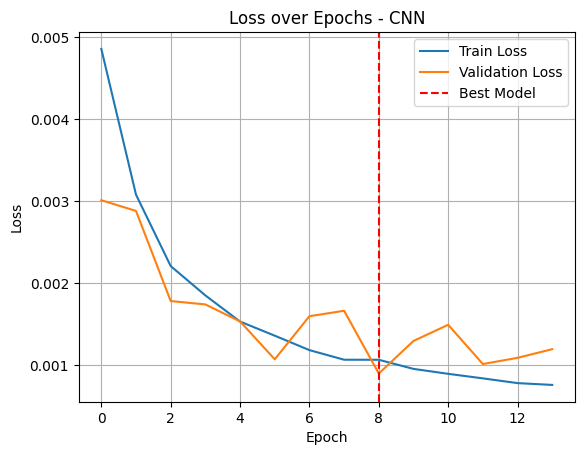

In [ ]:
# Visualize the train and val losses
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.axvline(best_epoch, color='r', linestyle='--', label='Best Model')
plt.title('Loss over Epochs - CNN')
plt.legend()
plt.show()

# Save model

In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/customCNN.pth')

In [ ]:
# load best model
model.load_state_dict(torch.load('/content/drive/My Drive/customCNN.pth'))
model.to(device)

FaceKeyPoints(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18432, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features

# Evaluation

In [ ]:
def evaluate_model(model, test_loader, criterion, device):
    """
    Evaluates the quality of the trained model on a test subset.\n

    Args:
        model (torch.nn.Module): A trained model whose quality needs to be evaluated.
        test_loader (torch.utils.data.DataLoader): Data loader for the test set.
        criterion (torch.nn.Module): A loss function used to evaluate the quality of model predictions.
        device: (torch.device): CPU or CUDA

    Returns:
        float: The average value of the loss function on the test dataset.
    """

    # switch model to evaluation mode
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for batch in test_loader:
            images, keypoints = batch['image'], batch['keypoints']
            images, keypoints = images.to(device).float(), keypoints.to(device).float()
            keypoints = keypoints.view(keypoints.size(0), -1)  # shape (batch_size, 136)

            outputs = model(images)
            loss = criterion(outputs, keypoints)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f'Test Loss: {avg_loss:.4f}')
    return avg_loss

In [ ]:
# Call the function evaluate_model after training
test_loss = evaluate_model(model, test_loader, criterion, device)

Test Loss: 0.0010


# Visualization

In [84]:
def show_keypoints(ax, image, predicted_keypoints=None, actual_keypoints=None):
    height, width = image.shape[:2]
    ax.imshow(image)
    if actual_keypoints is not None:
        actual_keypoints = actual_keypoints * [width, height]
        ax.scatter(actual_keypoints[:, 0], actual_keypoints[:, 1], s=50, marker='o', c='g', label='Actual')
    if predicted_keypoints is not None:
        predicted_keypoints = predicted_keypoints * [width, height]
        ax.scatter(predicted_keypoints[:, 0], predicted_keypoints[:, 1], s=50, marker='x', c='r', label='Predicted')
    ax.legend()
    ax.axis('off')

In [85]:
def visualize_predictions(dataset, model, device, num_images=6, images_per_row=3):
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)
    rows = num_images // images_per_row + int(num_images % images_per_row != 0)
    fig, axs = plt.subplots(rows, images_per_row, figsize=(20, 10))

    axs = axs.flatten()

    with torch.no_grad():
        for i, idx in enumerate(indices):
            sample = dataset[idx]
            image = sample['image'].unsqueeze(0).to(device).float()
            outputs = model(image)
            predicted_keypoints = outputs.view(-1, 2).cpu().numpy()
            actual_keypoints = sample['keypoints'].numpy()
            image = sample['image'].permute(1, 2, 0).numpy() * 255

            show_keypoints(axs[i], image, predicted_keypoints, actual_keypoints)

        for j in range(i + 1, len(axs)):
            fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

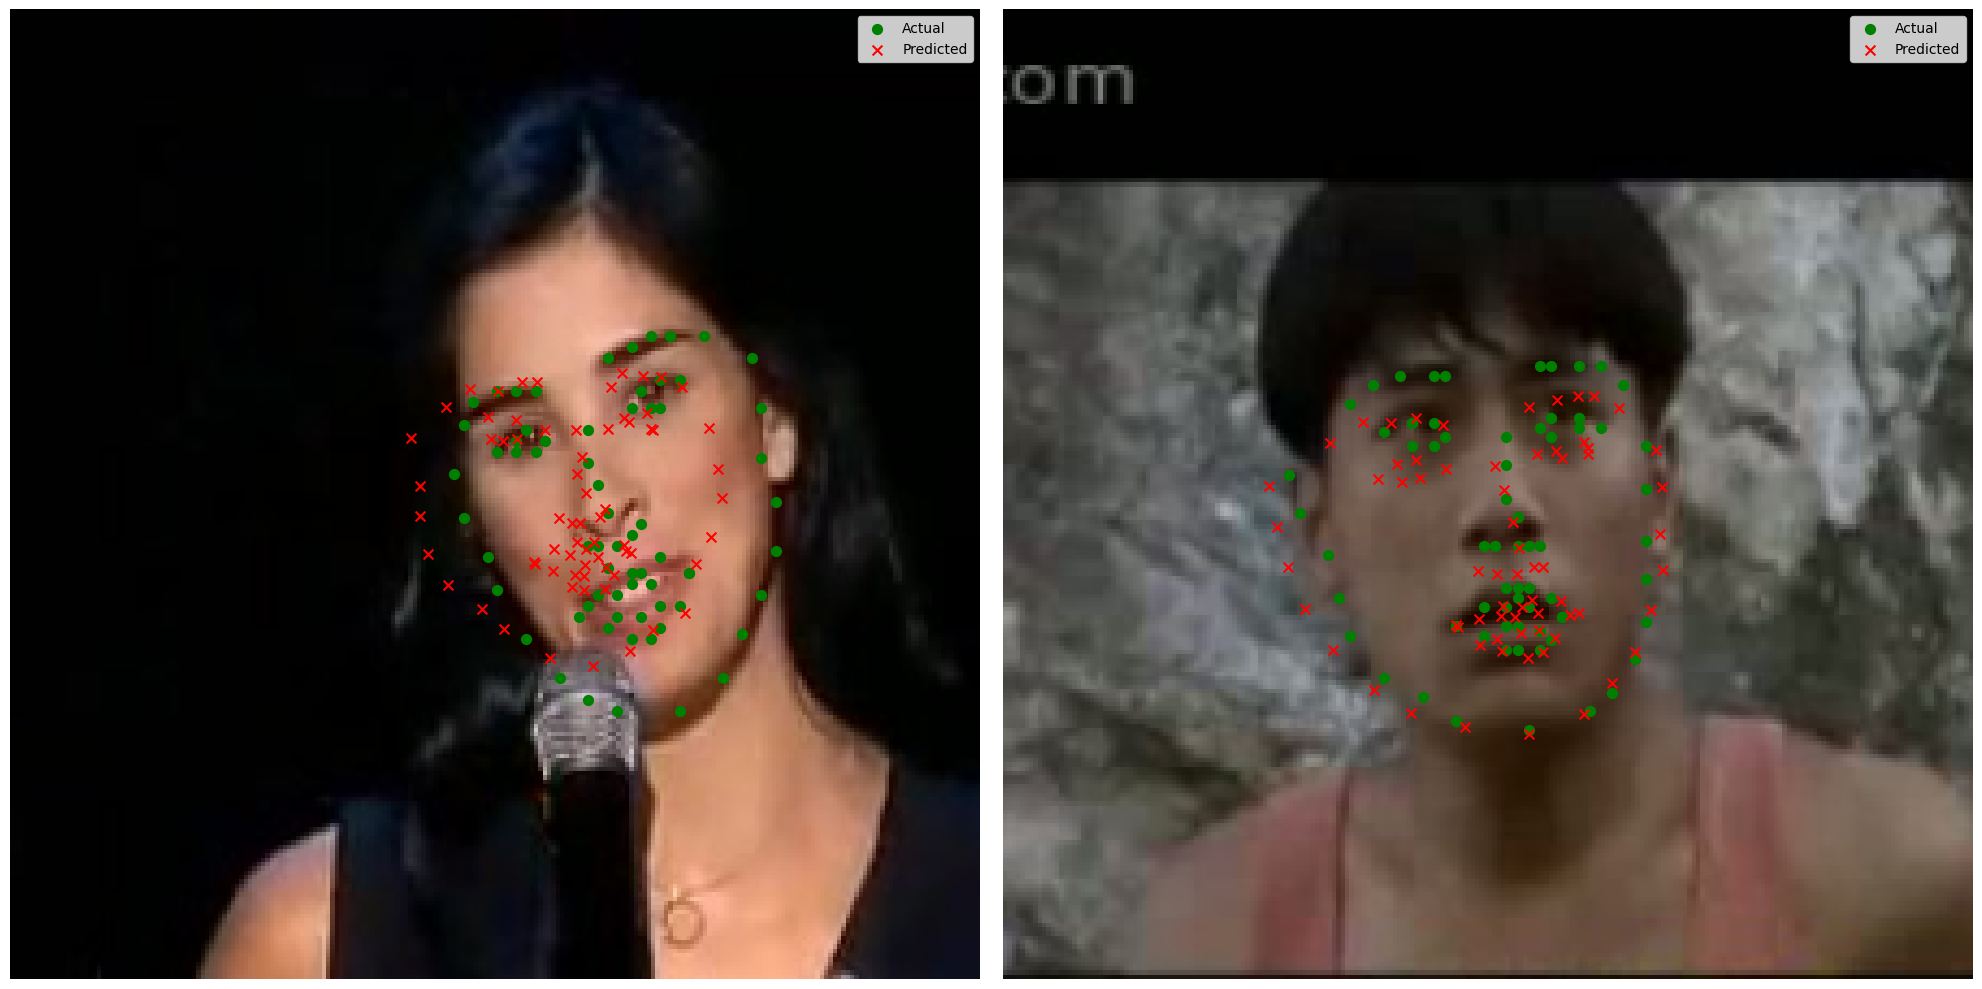

In [ ]:
# Call the function to visualize predictions
visualize_predictions(test_dataset, model, device, num_images=2, images_per_row=2)

# Conclusion

> ### After conducting countless experiments with the architecture of a custom CNN, it was not possible to achieve a better result than you can see above.

# So, let's dive into __pretrained CNN models__ in the next notebook.